![head.png](https://github.com/cafawo/FinancialDataAnalytics/blob/master/figures/head.jpg?raw=1)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

# Homework: time series analysis

You will need a Git/GitHub repository to submit your course deliverables. Consult [**slides.ipynb**](https://github.com/cafawo/FinancialDataAnalytics) for help with the tasks below! If you need further assistance, do not hesitate to open a Q&A at https://github.com/cafawo/FinancialDataAnalytics/discussions

In this assignment you will work with data that is stored in a file named **02_python_data.csv**, which contains daily stock prices for various companies listed on Deutsche Börse (Xetra). The columns are labeled with Reuters identifier code (RIC). The first RIC '.GDAXI' is the german DAX index, the remaining RICs represent its constituents.

In this exercise we will compare the **DAX index** (.GDAXI) to a portfolio build from the **constituents** (the remaining columns).

In [63]:
# Read data from CSV file
prices = pd.read_csv('02_python_data.csv', index_col=0, parse_dates=True)
returns = np.log(prices) - np.log(prices.shift(1))
returns = returns.iloc[1:,::]

### Task: 

Fit an ARMA(1,1) model to the DAX index and use that model to plot a 30 days forecast for the DAX index. Compare your results to an ARMA(5,5) model.

c:\Users\nb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


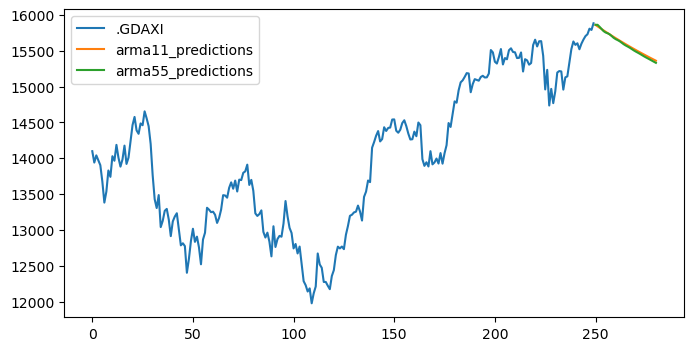

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# This avoids specifying the frequency of the price data
data = prices.reset_index()
n = len(data)

# Fit an MA model to the time series
arma11_fit = ARIMA(data['.GDAXI'], order=(1, 0, 1)).fit()
arma55_fit = ARIMA(data['.GDAXI'], order=(5, 0, 5)).fit()

# Make predictions
arma11_predictions = arma11_fit.predict(start=len(data['.GDAXI']), end=len(data['.GDAXI'])+30)
arma55_predictions = arma55_fit.predict(start=len(data['.GDAXI']), end=len(data['.GDAXI'])+30)

# Plot the time series and the predictions
plt.figure(figsize=(8, 4))
plt.plot(data['.GDAXI'], label='.GDAXI')
plt.plot(range(n, n+31), arma11_predictions, label='arma11_predictions')
plt.plot(range(n, n+31), arma55_predictions, label='arma55_predictions')
plt.legend()
plt.show()


### Task: 

In the previous homework, we created a replication portfolio and a smart-beta portfolio. Use the solution to **05_optimization.ipynb** and analyze if there exists a cointegration relationship between any of these portfolios and the DAX index.

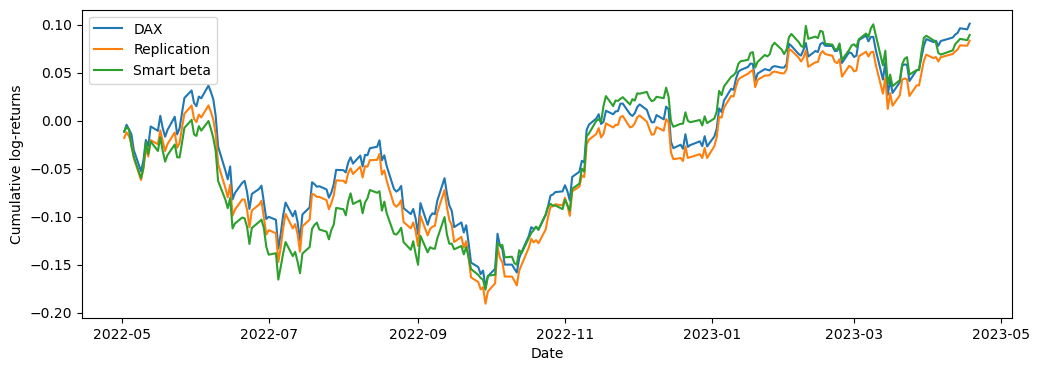

In [65]:
import numpy as np
import statsmodels.api as sm

# Replication model
fitted_model = sm.OLS(returns.iloc[::,0], returns.iloc[::,1:]).fit()
# The weights are simply the parameters from the linear model
weights_linreg = fitted_model.params

cumlogret = pd.DataFrame()

cumlogret[".GDAXI"] = np.log(1 + returns.iloc[:, 0]).cumsum()
cumlogret["Replication"] = np.log(1 + returns.iloc[:, 1:] @ weights_linreg).cumsum()
cumlogret["Smart beta"] = np.log(1 + returns[['SIEGn.DE', 'ALVG.DE', 'IFXGn.DE']] @ np.array([0.272915, 0.29325, 0.139683])).cumsum()

# create the figure and subplots
fig, ax1 = plt.subplots(figsize=(12,4))
# plot the data on the first y-axis
ax1.plot(cumlogret[".GDAXI"], label='DAX')
ax1.plot(cumlogret["Replication"], label='Replication')
ax1.plot(cumlogret["Smart beta"], label='Smart beta')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative log-returns')
# set the title of the plot
plt.legend()
# show the plot
plt.show()

In [66]:
from statsmodels.tsa.stattools import coint

score, pvalue, _ = coint(cumlogret[".GDAXI"], cumlogret["Replication"])
print(pvalue)

score, pvalue, _ = coint(cumlogret[".GDAXI"], cumlogret["Smart beta"])
print(pvalue)

0.4063730484311388
0.5239358945038528


### Task: 

Consider all the assets in **02_python_data.csv** (including the DAX) and test for any cointegration relationships among those assets.

In [67]:
import itertools

# get all combinations of 2 tickers
combinations = list(itertools.combinations(prices.columns, 2))

p_values = {}
for comb in combinations:
    a, b = comb
    _, pvalue, _ = coint(prices[a], prices[b])
    p_values[pvalue] = comb



p_values = dict(sorted(p_values.items(),  reverse = False))

significant_p_values = {p:p_values[p] for p in p_values if p <= 0.01}
print(f"Found {len(significant_p_values)} significant p-values using the ADF test.")
display(significant_p_values)


Found 8 significant p-values using the ADF test.


{0.002125331206714368: ('AIRG.DE', 'IFXGn.DE'),
 0.0028236494404479226: ('SHLG.DE', 'BAYGn.DE'),
 0.004534003939051483: ('ALVG.DE', 'DTGGe.DE'),
 0.005681967843202296: ('SHLG.DE', 'CONG.DE'),
 0.006906246850922299: ('SY1G.DE', 'CBKG.DE'),
 0.008053270733001636: ('SHLG.DE', 'EONGn.DE'),
 0.008884705038807025: ('SHLG.DE', 'RHMG.DE'),
 0.008888677999544058: ('ALVG.DE', 'IFXGn.DE')}

### Task: 

Should you find one or more cointegration relationships, pick one to analyze its dynamics using an error correction model (ECM).

In [68]:
# Define the two series to be analyzed
series1 = prices['AIRG.DE']
series2 = prices['IFXGn.DE']

# Fit a simple linear regression to the two series
model = sm.OLS(series1, series2)
results = model.fit()

# Get the residuals
residuals = results.resid

# Compute changes in series1 and series2
delta_series1 = np.diff(series1)
delta_series2 = np.diff(series2)

# Lag the residuals by one period
lagged_residuals = residuals[1:-1]

# Trim the changes to be the same length as lagged_residuals
delta_series1 = delta_series1[:-1]
delta_series2 = delta_series2[:-1]

# Put everything into a dataframe
df = pd.DataFrame({
    'Delta_Series1': delta_series1,
    'Delta_Series2': delta_series2,
    'Lagged_Residuals': lagged_residuals
})

# Fit the Error Correction Model
ecm_model = sm.OLS(df['Delta_Series2'], sm.add_constant(df[['Delta_Series1', 'Lagged_Residuals']]))
ecm_results = ecm_model.fit()
print(ecm_results.summary())


                            OLS Regression Results                            
Dep. Variable:          Delta_Series2   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     46.22
Date:                Wed, 24 May 2023   Prob (F-statistic):           9.31e-18
Time:                        14:54:35   Log-Likelihood:                -236.21
No. Observations:                 248   AIC:                             478.4
Df Residuals:                     245   BIC:                             489.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0300      0.040  